### Digit Classification Problem - Overview

In [1]:
# Notebook Preamble
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, Latex

In [2]:
# Loading data for Digit Recognizer Problem
training_set = pd.read_csv("DigitRecognizer.csv", nrows=5000)
# Summary of Dataframe
print('Dimensions', training_set.shape) 
print(training_set.axes)

Dimensions (5000, 785)
[RangeIndex(start=0, stop=5000, step=1), Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)]


- The data file DigitRecognizer.csv contains gray-scale images of hand-drawn digits, from zero through nine.
- Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. 
- The data set has 785 columns and 42K images. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. 

In [3]:
N = 5000 
X = training_set.loc[:, 'pixel0':'pixel783']
Y = training_set.loc[:, 'label']

In [4]:
print('X - Dimensions:', X.shape, ', Type:', type(X))
print('Y- Dimensions:', Y.shape, ', Type:', type(Y))

X - Dimensions: (5000, 784) , Type: <class 'pandas.core.frame.DataFrame'>
Y- Dimensions: (5000,) , Type: <class 'pandas.core.series.Series'>


<Figure size 432x288 with 0 Axes>

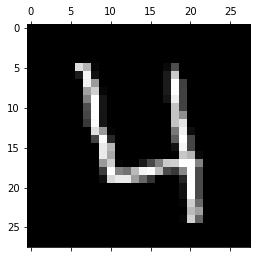

Lable for this image: 4


In [5]:
plt.gray()
plt.matshow(np.array(X.loc[3,:]).reshape((28,28)))
plt.show()
print('Lable for this image:', Y[3])

### Digit Classification Problem - Preprocessing and Dimensionality Reduction

In [6]:
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp

In [7]:
# Standardizing mean using StandardScaler() object
mean_datascaler = sklpp.StandardScaler(with_mean=True, with_std=False)
X_centered = mean_datascaler.fit_transform(X)
mean_vector = mean_datascaler.mean_

<Figure size 432x288 with 0 Axes>

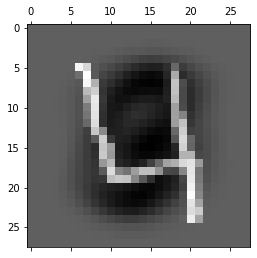

Lable for this image: 4


In [8]:
# Displaying the same image after data is centered
plt.gray()
plt.matshow(X_centered[3,:].reshape((28,28)))
plt.show()
print('Lable for this image:', Y[3])

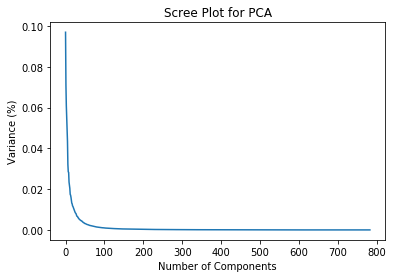

In [9]:
# creating an instance of the PCA() object
pca = skldecomp.PCA().fit(X_centered)
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Scree Plot for PCA')
plt.show()

From the Scree Plot, it can be seen that most of the variance is captured by less than first 100 principal components, i.e $k < 100$.

In [10]:
# creating an instance of the PCA() object that retains 90% information
data_pca = skldecomp.PCA(n_components=0.90, svd_solver='full') 
# using the fit_transform API to simultaneously compute PCA features and directions 
features_X = data_pca.fit_transform(X_centered) 
# printing the value of k, as returned by sklearn 
display(Latex(r'The value of the integer $k$ retaining 90% information is $k$ = {}.'.format(data_pca.n_components_)))

<IPython.core.display.Latex object>

In [11]:
# Reconstructing the image with k = 85
M = data_pca.components_[0:85,:]
X_tilde = X_centered@M.T
X_hat = mean_datascaler.inverse_transform(X_tilde@M)

<Figure size 432x288 with 0 Axes>

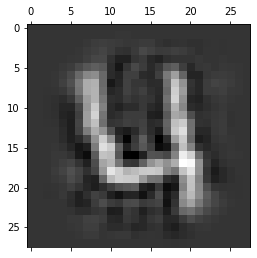

label for this image: 4


In [12]:
plt.gray() 
plt.matshow(X_hat[3,:].reshape((28,28))) 
plt.show()
print('label for this image:', Y[3])

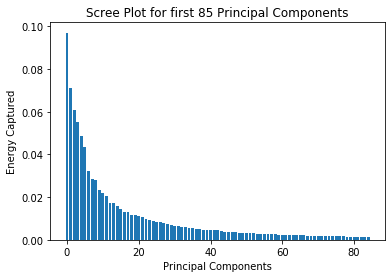

In [13]:
energy_captured = data_pca.explained_variance_ratio_
principal_components = [i for i in range(85)]
plt.bar(principal_components, energy_captured)
plt.title('Scree Plot for first 85 Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Energy Captured')
plt.show()

The chosen value for $k$ is $85$ since it captures 90% variability in the data.

In [14]:
# Modified data sets after Dimensionality Reduction
print('Independent Features:', X_tilde.shape, ', X_tilde Type:', type(X_tilde))
Y = np.array(Y)
print('Corresponding Labels:', Y.shape, ', Y Type:', type(Y))

Independent Features: (5000, 85) , X_tilde Type: <class 'numpy.ndarray'>
Corresponding Labels: (5000,) , Y Type: <class 'numpy.ndarray'>


### Digit Classification Problem - $K$ Nearest Neighors using 10 Fold Cross Validation

In [15]:
# Dividing Datset into 10 sets for 10 fold cross validation
k = 10
m = N//k  # m is the number of elements in each fold
print('Number of Samples in each Fold:', m)
SX = np.array_split(X_tilde, k)
SY = np.array_split(Y, k)
print('Number of Folds:', len(SX))
print('Dimensions of feature data in each fold:' , SX[0].shape)
print('Dimensions of label data in each fold:' , SY[0].shape)

Number of Samples in each Fold: 500
Number of Folds: 10
Dimensions of feature data in each fold: (500, 85)
Dimensions of label data in each fold: (500,)


In [16]:
def compute_yi_hat(x_i, training_data, training_labels, k):
    # here, x_i is 85 dimensional vector
    # Dimensions of training data is 4500
    euclidean_distance_vector = np.empty(len(training_data))   
    for i in range(len(training_data)):
        euclidean_distance_vector[i] = np.linalg.norm(x_i - training_data[i])            
    
    idx = np.argpartition(euclidean_distance_vector, k)
    nearest_neighors = idx[:k]  # list of indexes containing k nearest neighbors where k is atleast 1.
    
    yi_hat = [training_labels[nearest_neighors[i]] for i in range(k)]
    
    # Return the mode in the list yi_hat as the prediction
    return max(set(yi_hat), key=yi_hat.count)

In [17]:
Y_hat = np.empty(len(Y), int)
def compute_one_fold_error(test_data, test_labels, training_data, training_labels, k):
    # here test_data is 500 samples containing 85 features
    global Y_hat
    
    test_samples = len(test_data)
    misclassification_count = 0
    
    for i in range(test_samples):
        Y_hat[i] = compute_yi_hat(test_data[i], training_data, training_labels, k)
        if Y_hat[i] != test_labels[i]:
            misclassification_count += 1
    
    return misclassification_count/test_samples

Y_hat.shape

(5000,)

In [18]:
# Computing Error for the 1st fold in 10 fold cross validation
test_data = SX[0]
test_labels = SY[0]
training_data = SX[0+1]
training_labels = SY[0+1]
print(k, 'Fold Cross Validation')
for i in range(k):
    if i != 0 and i != 1:  
        training_data = np.concatenate((training_data, SX[i]), axis=0)
        training_labels = np.concatenate((training_labels, SY[i]), axis=0)

print('Dimensions of Test Data in Fold 1:', test_data.shape, test_labels.shape)
print('Dimensions of Training Data in Fold 1:', training_data.shape, training_labels.shape)

10 Fold Cross Validation
Dimensions of Test Data in Fold 1: (500, 85) (500,)
Dimensions of Training Data in Fold 1: (4500, 85) (4500,)


#### Error in first fold in 10 Fold Cross Validation for different values of $K$

In [19]:
# Analysis of First fold in 10 fold cross validation for different values of K Nearest Neighbors
Error_fold_1 = compute_one_fold_error(test_data, test_labels, training_data, training_labels, 1)
print('Error observed on Fold 1 in 10 Fold cross validation when K=1: ', Error_fold_1)
# K=3
Error_fold_1 = compute_one_fold_error(test_data, test_labels, training_data, training_labels, 3)
print('Error observed on Fold 1 in 10 Fold cross validation when K=3: ', Error_fold_1)
# K = 5
Error_fold_1 = compute_one_fold_error(test_data, test_labels, training_data, training_labels, 5)
print('Error observed on Fold 1 in 10 Fold cross validation when K=5: ', Error_fold_1)
# K = 7
Error_fold_1 = compute_one_fold_error(test_data, test_labels, training_data, training_labels, 7)
print('Error observed on Fold 1 in 10 Fold cross validation when K=7: ', Error_fold_1)

Error observed on Fold 1 in 10 Fold cross validation when K=1:  0.054
Error observed on Fold 1 in 10 Fold cross validation when K=3:  0.054
Error observed on Fold 1 in 10 Fold cross validation when K=5:  0.052
Error observed on Fold 1 in 10 Fold cross validation when K=7:  0.06


In [20]:
def compute_average_error_for_K_nearest_neighbor_classifier(data, labels, kfold, K_nearest_neighbors):
    global N
    SX = np.array_split(data, kfold)
    SY = np.array_split(labels, kfold)
    
    p_fold_error = np.zeros(kfold)
    
    for p in range(kfold):
        # Computing test data for fold p
        test_data = SX[p]
        test_labels = SY[p]
        # Computing training data for fold p
        training_folds = [i for i in range(kfold) if i != p]
        training_data = SX[training_folds[0]]
        training_labels = SY[training_folds[0]]
        for i in range(1, len(training_folds)): 
            training_data = np.concatenate((training_data, SX[training_folds[i]]), axis=0)
            training_labels = np.concatenate((training_labels, SY[training_folds[i]]), axis=0)
        # Computing average error for fold p and storing it in the p_fold_error numpy array
        p_fold_error[p] = compute_one_fold_error(test_data, test_labels, training_data, training_labels, K_nearest_neighbors)
        print('Error in Fold', (p+1), 'is', p_fold_error[p])
    
    return np.average(p_fold_error)

In [21]:
import time

In [22]:
avg_error = [0, 0, 0, 0]
time_taken = [0, 0, 0, 0]

#### Analysis for $K = 1$

In [23]:
print('Average error of K Nearest Neighbor Classifier using 10 Fold Cross-Validation Method when K = 1\n')
t0 = time.time()
avg_error[0] = compute_average_error_for_K_nearest_neighbor_classifier(X_tilde, Y, 10, 1)
time_taken[0] = time.time() - t0
print('\nAverage Error when K NN = 1:', round(avg_error[0], 3))
print('Time taken to compute average K NN error when K = 1:', round(time_taken[0], 2), ' seconds.')

Average error of K Nearest Neighbor Classifier using 10 Fold Cross-Validation Method when K = 1

Error in Fold 1 is 0.054
Error in Fold 2 is 0.064
Error in Fold 3 is 0.068
Error in Fold 4 is 0.074
Error in Fold 5 is 0.058
Error in Fold 6 is 0.07
Error in Fold 7 is 0.05
Error in Fold 8 is 0.082
Error in Fold 9 is 0.062
Error in Fold 10 is 0.062

Average Error when K NN = 1: 0.064
Time taken to compute average K NN error when K = 1: 219.3  seconds.


#### Analysis for $K = 3$

In [24]:
print('Average error of K Nearest Neighbor Classifier using 10 Fold Cross-Validation Method when K = 3\n')
t0 = time.time()
avg_error[1] = compute_average_error_for_K_nearest_neighbor_classifier(X_tilde, Y, 10, 3)
time_taken[1] = time.time() - t0
print('\nAverage Error when K NN = 3:', round(avg_error[1], 3))
print('Time taken to compute average K NN error when K = 3:', round(time_taken[1], 2), ' seconds.')

Average error of K Nearest Neighbor Classifier using 10 Fold Cross-Validation Method when K = 3

Error in Fold 1 is 0.054
Error in Fold 2 is 0.06
Error in Fold 3 is 0.064
Error in Fold 4 is 0.064
Error in Fold 5 is 0.06
Error in Fold 6 is 0.068
Error in Fold 7 is 0.06
Error in Fold 8 is 0.078
Error in Fold 9 is 0.062
Error in Fold 10 is 0.058

Average Error when K NN = 3: 0.063
Time taken to compute average K NN error when K = 3: 237.54  seconds.


#### Analysis for $K = 5$

In [25]:
print('Average error of K Nearest Neighbor Classifier using 10 Fold Cross-Validation Method when K = 5\n')
t0 = time.time()
avg_error[2] = compute_average_error_for_K_nearest_neighbor_classifier(X_tilde, Y, 10, 5)
time_taken[2] = time.time() - t0
print('\nAverage Error when K NN = 5:', round(avg_error[2], 3))
print('Time taken to compute average K NN error when K = 5:', round(time_taken[2], 2), ' seconds.')

Average error of K Nearest Neighbor Classifier using 10 Fold Cross-Validation Method when K = 5

Error in Fold 1 is 0.052
Error in Fold 2 is 0.07
Error in Fold 3 is 0.066
Error in Fold 4 is 0.07
Error in Fold 5 is 0.06
Error in Fold 6 is 0.066
Error in Fold 7 is 0.062
Error in Fold 8 is 0.078
Error in Fold 9 is 0.058
Error in Fold 10 is 0.07

Average Error when K NN = 5: 0.065
Time taken to compute average K NN error when K = 5: 242.44  seconds.


#### Analysis for $K = 7$

In [26]:
print('Average error of K Nearest Neighbor Classifier using 10 Fold Cross-Validation Method when K = 7\n')
t0 = time.time()
avg_error[3] = compute_average_error_for_K_nearest_neighbor_classifier(X_tilde, Y, 10, 7)
time_taken[3] = time.time() - t0
print('\nAverage Error when K NN = 7:', round(avg_error[3], 3))
print('Time taken to compute average K NN error when K = 7:', round(time_taken[3], 2), ' seconds.')

Average error of K Nearest Neighbor Classifier using 10 Fold Cross-Validation Method when K = 7

Error in Fold 1 is 0.06
Error in Fold 2 is 0.074
Error in Fold 3 is 0.07
Error in Fold 4 is 0.066
Error in Fold 5 is 0.056
Error in Fold 6 is 0.058
Error in Fold 7 is 0.076
Error in Fold 8 is 0.078
Error in Fold 9 is 0.052
Error in Fold 10 is 0.08

Average Error when K NN = 7: 0.067
Time taken to compute average K NN error when K = 7: 229.67  seconds.


#### Average Error and Best $K$ on this data

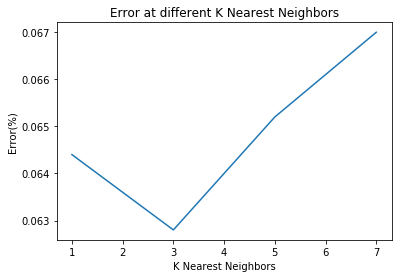

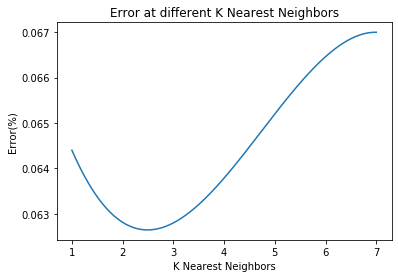

In [27]:
# Plotting Average Error on different values of K
from scipy.interpolate import make_interp_spline, BSpline

K_NN = [1, 3, 5, 7]
plt.plot(K_NN, avg_error)
plt.title('Error at different K Nearest Neighbors')
plt.xlabel('K Nearest Neighbors')
plt.ylabel('Error(%)')
plt.show()

# Smoothing Effect
xnew = np.linspace(min(K_NN), max(K_NN), 300)
spl = make_interp_spline(K_NN, avg_error, k=3)
error_smooth = spl(xnew)
plt.plot(xnew, error_smooth)
plt.title('Error at different K Nearest Neighbors')
plt.xlabel('K Nearest Neighbors')
plt.ylabel('Error(%)')
plt.show()

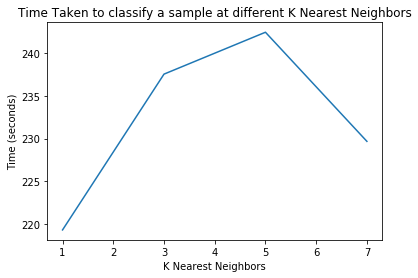

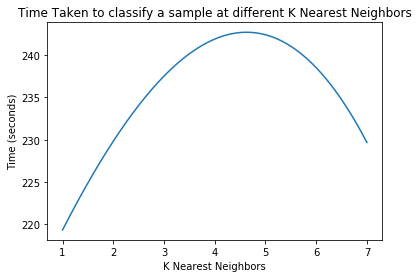

In [28]:
# Plotting Time Taken to classify at different values of K
plt.plot(K_NN, time_taken)
plt.title('Time Taken to classify a sample at different K Nearest Neighbors')
plt.xlabel('K Nearest Neighbors')
plt.ylabel('Time (seconds)')
plt.show()

# Smoothing Effect
xnew = np.linspace(min(K_NN), max(K_NN), 300)
spl = make_interp_spline(K_NN, time_taken, k=3)
time_smooth = spl(xnew)
plt.plot(xnew, time_smooth)
plt.title('Time Taken to classify a sample at different K Nearest Neighbors')
plt.xlabel('K Nearest Neighbors')
plt.ylabel('Time (seconds)')
plt.show() 

The value of K that yields the most accurate results on this Dataset is ***K = 3*** Nearest Neighbors. It is **93.7% accurate** on this dataset. The drawback is that this process is computationally expensive and requires time to make a decision.